In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers

In [3]:
# Read text transcripts and audio features data from drive

from google.colab import auth
import gspread
from google.auth import default
import pandas as pd

#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

worksheet = gc.open('train').sheet1
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
df_text = pd.DataFrame.from_records(rows[1:], columns=rows[0])

worksheet = gc.open('audio_features').sheet1
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# Convert to a DataFrame and render.
df_audio_feat = pd.DataFrame.from_records(rows[1:], columns=rows[0])


In [4]:
# Display the size of text and audio data
print("Size of text data:", df_text.shape)
print("Size of audio features data:", df_audio_feat.shape)

Size of text data: (10602, 6)
Size of audio features data: (10602, 176)


In [5]:
# First few rows of text
df_text.head()

,Unnamed: 0,Filename,Label,fold,encoded_labels,transcript
0,0,/content/drive/MyDrive/DS5500/cremad/AudioWAV/...,anger,1,0,"Say the word, meal."
1,1,/content/drive/MyDrive/DS5500/cremad/AudioWAV/...,disgust,4,1,Say the word mob.
2,2,/content/drive/MyDrive/DS5500/cremad/AudioWAV/...,fear,2,2,Say the word mode.
3,3,/content/drive/MyDrive/DS5500/cremad/AudioWAV/...,happiness,3,3,Say the word mood.
4,4,/content/drive/MyDrive/DS5500/cremad/AudioWAV/...,neutral,0,4,Say the word moon.


In [6]:
# Distribution of samples across different classes
df_text['encoded_labels'].value_counts()

0    1731
1    1731
2    1731
3    1731
5    1671
4    1607
6     400
Name: encoded_labels, dtype: int64

In [7]:
# First few rows of audio features
df_audio_feat.head()

,0,1,2,3,4,5,6,7,8,9,...,166,167,168,169,170,171,172,173,174,Label
0,0.1026075932,0.6608564854,0.7001805902,0.6882741451,0.6785336733,0.6510103345,0.5747713447,0.5811648965,0.6380423307,0.6679651141,...,15.54763855,16.28087974,12.09981649,0.009888046634,0.01315528804,-0.03708244799,-0.05640051894,0.009006643415,0.007478937713,anger
1,0.0930710884,0.7176576853,0.7391351461,0.6608174443,0.6646335721,0.6899496913,0.6168180108,0.5880721807,0.6048464775,0.6695224047,...,14.5026511,15.33535345,12.60919793,-0.01407379782,-0.02234629061,-0.03215680416,-0.04239009981,0.01448988686,0.0003158722602,disgust
2,0.08429673139,0.625620544,0.6725063324,0.6530716419,0.6564134359,0.6118376255,0.5943345428,0.6051046848,0.6742022038,0.6930679679,...,15.03031176,15.58521655,12.74707717,-0.008794703459,0.03637488953,-0.02776887001,-0.03692989004,0.01885680685,0.005799294095,fear
3,0.08537618523,0.6388478279,0.668915689,0.672979176,0.6807129383,0.6617549062,0.6610633135,0.5830939412,0.595508635,0.6435089707,...,15.09814098,16.11714276,12.5990005,-0.003487213492,0.02527223807,-0.04519650456,-0.03336849283,-0.004738157377,0.002794266838,happiness
4,0.08232996324,0.7063750029,0.6805562973,0.6692967415,0.6734784245,0.6416030526,0.5808079839,0.5956234336,0.640729785,0.6743718982,...,14.9546421,16.4553915,12.51594918,0.01856141694,0.005002080018,-0.02516576017,-0.0367690406,0.01082131317,0.006420490715,neutral


In [8]:
# Audio features are loaded in as objects. Convert to float

# Convert columns to numeric, replacing empty strings with NaN
columns_to_convert = df_audio_feat.columns[df_audio_feat.columns != 'Label']
df_audio_feat[columns_to_convert] = df_audio_feat[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert NaN values to 0 or any default value if needed
df_audio_feat.fillna(0, inplace=True)

# Convert columns to float
df_audio_feat[columns_to_convert] = df_audio_feat[columns_to_convert].astype(float)

In [9]:
# Check for null values if any
df_text.isna().sum()

Unnamed: 0        0
Filename          0
Label             0
fold              0
encoded_labels    0
transcript        0
dtype: int64

In [10]:
# Check for null values if any
df_audio_feat.isna().sum().sum()

0

In [21]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from sklearn.metrics import roc_auc_score
import pickle
import os

tf.random.set_seed(42)

In [22]:
# BERT Tokenizer and Model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [23]:
# Function to generate bert embeddings
def generate_bert_embeddings(tokenizer, model, texts, fold, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_encoding = tokenizer(batch_texts,
                                   padding=True,
                                   truncation=True,
                                   max_length=30,
                                   return_tensors='tf')
        batch_output = model(batch_encoding)
        batch_embeddings = batch_output.last_hidden_state[:, 0, :]  # Extract [CLS] token embedding
        embeddings.append(batch_embeddings)

    model_filename = f'bert_model_{fold}.pkl'

    # Check if the file exists, if yes, remove it
    if os.path.exists(model_filename):
        os.remove(model_filename)

    # Store the model for future use
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model, model_file)
    print(f"Model for fold {fold} saved as {model_filename}")

    return tf.concat(embeddings, axis=0)

In [24]:
# Classifier function
def model_train_evaluate(X_train, y_train, X_test, y_test, fold):

  input = Input(shape=(X_train.shape[1],))
  hidden1 = Dense(512, activation='relu')(input)
  hidden2 = Dense(128, activation='relu')(hidden1)
  hidden3 = Dense(64, activation='relu')(hidden2)
  output = Dense(7, activation='softmax')(hidden3)
  model = Model(inputs=input, outputs=output)

  model.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['acc'])

  model.fit(X_train, y_train, epochs = 50,
                validation_split=0.1)

  model_filename = f'classifier_model_{fold}.pkl'

  # Check if the file exists, if yes, remove it
  if os.path.exists(model_filename):
      os.remove(model_filename)

  # Store the model for future use
  with open(model_filename, 'wb') as model_file:
      pickle.dump(model, model_file)

  print(f"Model for fold {fold} saved as {model_filename}")

  loss, accuracy= model.evaluate(X_test, y_test)

  test_predictions = model.predict(X_test)
  test_auc = roc_auc_score(y_test, test_predictions, multi_class='ovr')

  return loss, accuracy, test_auc

In [25]:
# Drop lables in audio
X_audio = df_audio_feat.drop(columns = ['Label'])

accuracy_dict = {}
loss_dict = {}
auc_roc_dict = {}

train = []
test = []
fold = []

# Loop through each folds data, split train and test, evaluate
for i in np.unique(df_text['fold']):
  fold.append(i)

  # Create X_train and X_test based on 'fold' column
  X_train = df_text.loc[df_text['fold'] != i, 'transcript'].values
  train_indices = df_text.index[df_text['fold'] != i].tolist()
  X_test = df_text.loc[df_text['fold'] == i, 'transcript'].values
  test_indices = df_text.index[df_text['fold'] == i].tolist()

  # Create y_train and y_test based on 'fold' column
  y_train = df_text.loc[df_text['fold'] != i, 'encoded_labels'].values
  y_test = df_text.loc[df_text['fold'] == i, 'encoded_labels'].values

  X_train_audio = X_audio[X_audio.index.isin(train_indices)]
  X_test_audio = X_audio[X_audio.index.isin(test_indices)]

  # Tokenize and pad text data for BERT input using batch processing
  batch_size = 32  # Set the batch size for BERT processing
  print(f"{i}th Fold BERT embeddings start")
  bert_output_train = generate_bert_embeddings(bert_tokenizer, bert_model, list(X_train), int(i)+1, batch_size=batch_size)
  bert_output_test = generate_bert_embeddings(bert_tokenizer, bert_model, list(X_test), int(i)+1, batch_size=batch_size)
  print(f"{i}th Fold BERT embeddings done")


  # Concatenate text features with audio features
  audio_train_tensor = tf.convert_to_tensor(X_train_audio, dtype=tf.float32)
  concatenated_features_train = tf.concat([bert_output_train, audio_train_tensor], axis=1)
  audio_test_tensor = tf.convert_to_tensor(X_test_audio, dtype=tf.float32)
  concatenated_features_test = tf.concat([bert_output_test, audio_test_tensor], axis=1)

  train.append(concatenated_features_train.shape)
  test.append(concatenated_features_test.shape)

  # Categorize the labels
  num_classes = len(set(y_train))  # Assuming 'y_train' contains the class labels
  y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
  y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

  print(f"{i}th Fold model evaluation start")
  loss, accuracy, auc_roc = model_train_evaluate(concatenated_features_train, y_train_cat, concatenated_features_test, y_test_cat, int(i)+1)
  print(f"{i}th Fold model evaluation end")

  loss_dict[i] = round(loss, 2)
  accuracy_dict[i] = round(accuracy*100, 2)
  auc_roc_dict[i] = round(auc_roc*100,2)

  print("fold:", i, "completely done")


0th Fold BERT embeddings start


/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Model for fold 1 saved as bert_model_1.pkl
Model for fold 1 saved as bert_model_1.pkl
0th Fold BERT embeddings done
0th Fold model evaluation start
Epoch 1/50
239/239 [==============================] - 4s 13ms/step - loss: 2.6693 - acc: 0.2615 - val_loss: 3.6197 - val_acc: 0.0365
Epoch 2/50
239/239 [==============================] - 4s 17ms/step - loss: 1.6970 - acc: 0.3377 - val_loss: 4.0594 - val_acc: 0.0400
Epoch 3/50
239/239 [==============================] - 3s 14ms/step - loss: 1.5789 - acc: 0.3781 - val_loss: 4.9279 - val_acc: 0.1119
Epoch 4/50
239/239 [==============================] - 2s 10ms/step - loss: 1.4534 - acc: 0.4249 - val_loss: 4.6672 - val_acc: 0.0860
Epoch 5/50
239/239 [==============================] - 2s 10ms/step - loss: 1.4159 - acc: 0.4355 - val_loss: 5.0292 - val_acc: 0.1378
Epoch 6/50
239/239 [==============================] - 3s 12ms/step - loss: 1.3861 - acc: 0.4507 - val_loss: 4.3594 - val_acc: 0.1095
Epoch 7/50
239/239 [==============================] - 

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Model for fold 2 saved as bert_model_2.pkl
Model for fold 2 saved as bert_model_2.pkl
1th Fold BERT embeddings done
1th Fold model evaluation start
Epoch 1/50
239/239 [==============================] - 5s 10ms/step - loss: 2.5926 - acc: 0.2560 - val_loss: 4.0295 - val_acc: 0.0106
Epoch 2/50
239/239 [==============================] - 3s 12ms/step - loss: 1.7672 - acc: 0.3378 - val_loss: 3.4560 - val_acc: 0.0259
Epoch 3/50
239/239 [==============================] - 3s 14ms/step - loss: 1.5501 - acc: 0.3880 - val_loss: 3.8861 - val_acc: 0.0518
Epoch 4/50
239/239 [==============================] - 4s 18ms/step - loss: 1.4583 - acc: 0.4224 - val_loss: 3.7167 - val_acc: 0.0860
Epoch 5/50
239/239 [==============================] - 2s 10ms/step - loss: 1.4041 - acc: 0.4374 - val_loss: 4.6670 - val_acc: 0.0506
Epoch 6/50
239/239 [==============================] - 3s 11ms/step - loss: 1.3305 - acc: 0.4613 - val_loss: 4.7879 - val_acc: 0.0506
Epoch 7/50
239/239 [==============================] - 

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Model for fold 3 saved as bert_model_3.pkl
Model for fold 3 saved as bert_model_3.pkl
2th Fold BERT embeddings done
2th Fold model evaluation start
Epoch 1/50
239/239 [==============================] - 4s 11ms/step - loss: 2.3900 - acc: 0.2627 - val_loss: 2.5374 - val_acc: 0.0518
Epoch 2/50
239/239 [==============================] - 2s 10ms/step - loss: 1.7050 - acc: 0.3208 - val_loss: 2.9373 - val_acc: 0.0801
Epoch 3/50
239/239 [==============================] - 3s 11ms/step - loss: 1.5394 - acc: 0.3805 - val_loss: 2.6686 - val_acc: 0.1413
Epoch 4/50
239/239 [==============================] - 3s 13ms/step - loss: 1.4829 - acc: 0.4106 - val_loss: 3.4323 - val_acc: 0.0742
Epoch 5/50
239/239 [==============================] - 4s 16ms/step - loss: 1.3963 - acc: 0.4384 - val_loss: 4.2631 - val_acc: 0.0671
Epoch 6/50
239/239 [==============================] - 3s 12ms/step - loss: 1.3375 - acc: 0.4642 - val_loss: 4.6460 - val_acc: 0.0683
Epoch 7/50
239/239 [==============================] - 

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Model for fold 4 saved as bert_model_4.pkl
Model for fold 4 saved as bert_model_4.pkl
3th Fold BERT embeddings done
3th Fold model evaluation start
Epoch 1/50
239/239 [==============================] - 4s 13ms/step - loss: 2.4235 - acc: 0.2709 - val_loss: 3.8535 - val_acc: 0.0577
Epoch 2/50
239/239 [==============================] - 3s 11ms/step - loss: 1.7048 - acc: 0.3379 - val_loss: 4.0775 - val_acc: 0.0742
Epoch 3/50
239/239 [==============================] - 3s 15ms/step - loss: 1.5406 - acc: 0.3862 - val_loss: 4.1596 - val_acc: 0.0648
Epoch 4/50
239/239 [==============================] - 3s 14ms/step - loss: 1.4649 - acc: 0.4132 - val_loss: 4.6122 - val_acc: 0.0660
Epoch 5/50
239/239 [==============================] - 3s 14ms/step - loss: 1.3780 - acc: 0.4553 - val_loss: 4.7308 - val_acc: 0.0801
Epoch 6/50
239/239 [==============================] - 3s 11ms/step - loss: 1.3240 - acc: 0.4754 - val_loss: 6.1663 - val_acc: 0.0730
Epoch 7/50
239/239 [==============================] - 

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Model for fold 5 saved as bert_model_5.pkl
Model for fold 5 saved as bert_model_5.pkl
4th Fold BERT embeddings done
4th Fold model evaluation start
Epoch 1/50
239/239 [==============================] - 4s 10ms/step - loss: 2.4822 - acc: 0.2750 - val_loss: 6.1287 - val_acc: 0.0224
Epoch 2/50
239/239 [==============================] - 4s 15ms/step - loss: 1.6841 - acc: 0.3510 - val_loss: 4.5220 - val_acc: 0.0518
Epoch 3/50
239/239 [==============================] - 6s 27ms/step - loss: 1.5186 - acc: 0.4005 - val_loss: 5.4073 - val_acc: 0.0412
Epoch 4/50
239/239 [==============================] - 4s 18ms/step - loss: 1.4205 - acc: 0.4352 - val_loss: 4.8819 - val_acc: 0.0471
Epoch 5/50
239/239 [==============================] - 4s 15ms/step - loss: 1.4083 - acc: 0.4420 - val_loss: 5.1669 - val_acc: 0.0495
Epoch 6/50
239/239 [==============================] - 4s 15ms/step - loss: 1.3411 - acc: 0.4575 - val_loss: 5.9689 - val_acc: 0.0459
Epoch 7/50
239/239 [==============================] - 

In [26]:
folds = np.unique(df_text['fold'])
folds = [int(x)+1 for x in folds]

results = pd.DataFrame({'Fold':folds, 'Accuracy': list(accuracy_dict.values()), 'AUC-ROC scores': list(auc_roc_dict.values())})
results

,Fold,Accuracy,AUC-ROC scores
0,1,49.98,80.84
1,2,51.44,81.40
2,3,51.04,80.16
3,4,51.60,82.60
4,5,51.56,83.08


In [27]:
split_df = pd.DataFrame({'Fold':folds, 'Train_Size': train, 'Test_Size':test})
split_df

,Fold,Train_Size,Test_Size
0,1,"(8481, 943)","(2121, 943)"
1,2,"(8481, 943)","(2121, 943)"
2,3,"(8482, 943)","(2120, 943)"
3,4,"(8482, 943)","(2120, 943)"
4,5,"(8482, 943)","(2120, 943)"


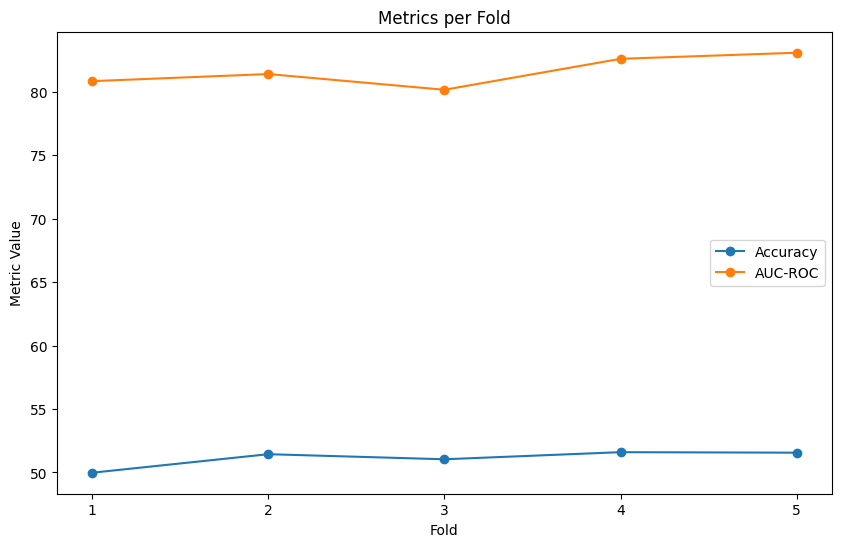

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(folds, list(accuracy_dict.values()), marker='o', label='Accuracy')
plt.plot(folds, list(auc_roc_dict.values()), marker='o', label='AUC-ROC')
plt.xlabel('Fold')
plt.ylabel('Metric Value')
plt.title('Metrics per Fold')
plt.xticks(folds)
plt.legend()
plt.show()

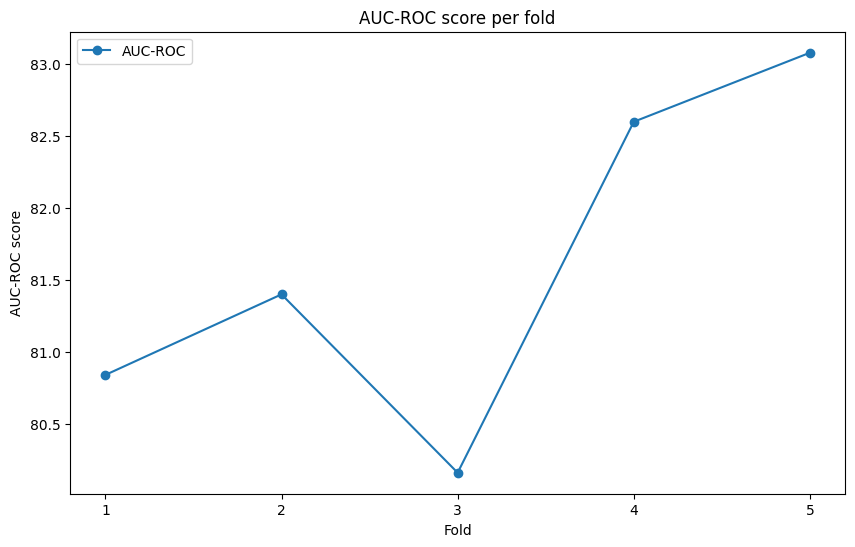

In [29]:
# Plot AUC-ROC scores for each fold

plt.figure(figsize=(10, 6))
plt.plot(folds, list(auc_roc_dict.values()), marker='o', label='AUC-ROC')
plt.xlabel('Fold')
plt.ylabel('AUC-ROC score')
plt.title('AUC-ROC score per fold')
plt.xticks(folds)
plt.legend()
plt.show()